## Goal




In [1]:
msname = "./AS110/scienceData.RACS_0012+00.SB45305.RACS_0012+00.beam00_averaged_cal.leakage.ms/"

## Imaging with ASKAP imager

In [2]:
from taitale import taitale_env

env = taitale_env(
    image = "csirocass/askapsoft",
    tag = "1.17.6-openmpi4"
)


In [3]:
from taitale.askap import imager, mslist

mslist(env=env, args=f"--full {msname}", logfile="mslist.txt")

Starting mslist
mslist complete


In [4]:
!cat mslist.txt

Debug: registered context Global=0
2025-02-14 10:05:29	INFO		   Observer:      Project:   
2025-02-14 10:05:29	INFO	+	Observation: ASKAP(36 antennas)
2025-02-14 10:05:29	INFO	MSMetaData::_computeScanAndSubScanProperties 	Computing scan and subscan properties...
2025-02-14 10:05:29	INFO		Data records: 21312       Total elapsed time = 318.505 seconds
2025-02-14 10:05:29	INFO	+	   Observed from   29-Oct-2022/14:11:38.4   to   29-Oct-2022/14:16:56.9 (UTC)
2025-02-14 10:05:29	INFO		
2025-02-14 10:05:29	INFO		Fields: 1
2025-02-14 10:05:29	INFO	+	  ID   Code Name                            RA               Decl           Epoch        nRows
2025-02-14 10:05:29	INFO	+	  0         RACS_0012+00                    00:12:24.827000 +00.00.00.00000 J2000        21312
2025-02-14 10:05:29	INFO		Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
2025-02-14 10:05:29	INFO	+	  SpwID  Name    #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs          
2025-

In [5]:
source_name = "RACS_0012+00"
image_name = f"image.i.{source_name}"
nchan = 288
ra="00:12:24.827000"
dec="+00.00.00.00000"
direction=f"[{ra}, {dec}, J2000]"

In [7]:
from taitale.askap import imager

imaging_workers = 1
nchanpercore = nchan // imaging_workers

print(f"channels: {nchan}")
print(f"nchanpercore: {nchanpercore}")
print(f"mpi_workers: {imaging_workers}")

# Default parset for Clean used
imager(
    env=env,
    workers=imaging_workers+1,
    parset="./parsets/cimager.in",
    args={
        "dataset": f"./{msname}",
        "Images.Names": image_name,
        f"Images.{image_name}.direction": direction,
        f"Images.{image_name}.nchan": 1,
        f"Images.{image_name}.nterms": 2,
        "Images.shape": "[2048, 2048]",
        "Images.cellsize": "['2.5arcsec', '2.5arcsec']",
        "nchanpercore": nchanpercore,
        "restore": True,
    }
)

channels: 288
nchanpercore: 288
mpi_workers: 1
Starting imager


Debug: registered context Global=0
Debug: registered context Global=0


imager complete


Filename: image.i.RACS_0012+00.taylor.0.restored.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      64   (2048, 2048, 1, 1)   float32   
None


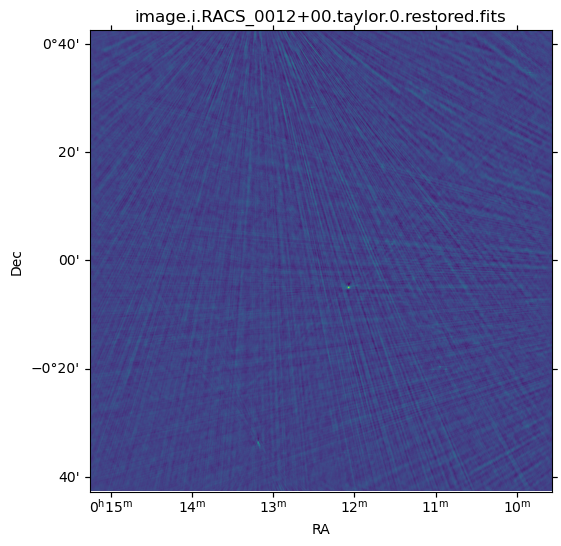

In [28]:
# Let's have a look at our image

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.io import fits
from astropy.wcs import WCS

%matplotlib inline

file = f'image.i.{source_name}.taylor.0.restored.fits'

# Using one of the files to setup WCS projection
hdu = fits.open(file)[0]

wcs = WCS(hdu.header, naxis=2)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw=dict(projection=wcs))

print(fits.info(file))
hdu = fits.open(file)[0]

im = ax.imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis')
# , norm=mcolors.PowerNorm(0.3))

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_autoscale_on(False)
ax.set_title(file)
# plt.colorbar(im, ax=ax)

plt.show()


## Imaging the same data with wsclean

> Note: This example is using an image of wsclean made by the community

In [16]:
# Note: This is a community image
wsclean_env = taitale_env(
    runtime="container",
    image="docker.io/alecthomson/wsclean",
    tag="v3.5",
)

In [17]:
wsclean_env

{'runtime': 'container',
 'engine': 'podman',
 'image': 'docker.io/alecthomson/wsclean',
 'tag': 'v3.5',
 'workload_manager': 'mpi',
 'dirty': 'False',
 'user_defaults': True,
 'dryrun': 'False',
 'ipy': 'False',
 'mpi': {'workload_exec': 'mpiexec -n {workers} {cmd}'},
 'slurm': {'workload_exec': 'srun --nodes={nodes} --ntasks={workers} {cmd}'},
 'native': {'exec': '{workload_exec} > {logfile}{pipestderr}'},
 'container': {'exec': '{engine} run --rm -v $PWD:/wsclean/:U {image}:{tag} {workload_exec} > {logfile}{pipestderr}'}}

In [26]:
from taitale.lofar import wsclean

wsclean(
    env=wsclean_env,
    args="-no-update-model-required -verbose "
        "-size 2048 2048 -scale 2.5arcsec -pol I -mgain 0.85 -niter 50000 "
        "-auto-threshold 3 -log-time "
        f"-no-mf-weighting -name wsclean-{source_name} {msname}"
)

Starting wsclean
wsclean complete


Filename: wsclean-RACS_0012+00-image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (2048, 2048, 1, 1)   float32   
None


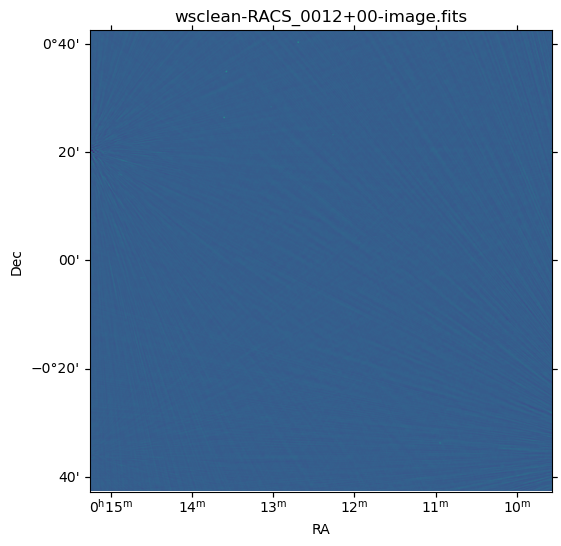

In [29]:
# Let's have a look at our image

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.io import fits
from astropy.wcs import WCS

%matplotlib inline

file = f'wsclean-RACS_0012+00-image.fits'

# Using one of the files to setup WCS projection
hdu = fits.open(file)[0]

wcs = WCS(hdu.header, naxis=2)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw=dict(projection=wcs))

print(fits.info(file))
hdu = fits.open(file)[0]

im = ax.imshow(hdu.data[0,0,:,:], origin='lower', cmap='viridis')

# , norm=mcolors.PowerNorm(0.3))

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_autoscale_on(False)
ax.set_title(file)
# plt.colorbar(im, ax=ax)

plt.show()
